In [2]:
import matplotlib.pyplot as plt

from skimage import io, color
from skimage.transform import rescale
from skimage.draw import rectangle
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu
from skimage.morphology import closing, square
import h5py

In [2]:
def load_transform(image_path):
    img = io.imread(image_path)
    img = img[25:195,0:160]
    img_gray = color.rgb2gray(img)
    
    thresh = threshold_otsu(img_gray)
    bw = closing(img_gray > thresh, square(3))
    cleared = bw
    label_image = label(cleared)
    for region in regionprops(label_image):
        if region.area >= 10:
            minr, minc, maxr, maxc = region.bbox
            rr, cc = rectangle(start=(minr, minc), end=(maxr, maxc), shape=cleared.shape)
            cleared[rr, cc] = 1

    image_rescaled = rescale(cleared, 1.0 / 3.0, anti_aliasing=False)
    return image_rescaled



(57, 53)


/home/andres/thesis/keras/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/andres/thesis/keras/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


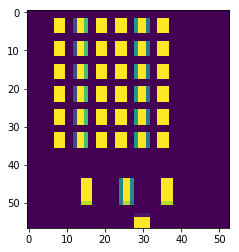

In [3]:
loaded = load_transform('/media/andres/Data/spaceinvaders/atari_v1/screens/spaceinvaders/1/1.png')
print(loaded.shape)
plt.imshow(loaded)

In [7]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
# encoding_dim = 256  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(3021,))
# "encoded" is the encoded representation of the input
encoded = Dense(1024, activation='relu')(input_img)
encoded = Dense(128, activation='relu')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(1024, activation='relu')(encoded)
decoded = Dense(3021, activation='sigmoid')(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

Using TensorFlow backend.


In [8]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3021)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              3094528   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              132096    
_________________________________________________________________
dense_4 (Dense)              (None, 3021)              3096525   
Total params: 6,454,349
Trainable params: 6,454,349
Non-trainable params: 0
_________________________________________________________________


In [9]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(128,))

In [10]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

type(x_train)

In [7]:
from os import listdir, path, walk
import numpy as np

num_to_load = 100000
split = int(num_to_load * 0.8)

data_path = '/media/andres/Data/spaceinvaders/atari_v1/screens/spaceinvaders'
data = np.zeros(shape=(num_to_load, 57, 53))
i = 0
for x in listdir(data_path):
    current_path = path.join(data_path, x)
    data_paths = [path.join(current_path, image) for image in listdir(current_path)]
    for image in data_paths:
        data[i] = load_transform(image)
        i = i + 1
        if i >= num_to_load:
            break
    print("loaded: {}".format(i))
    if i >= num_to_load:
        break
np.random.shuffle(data)
print("loaded shape: ", data.shape)

x_train = data[0:split]
x_test = data[split:]

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

/home/andres/thesis/keras/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/andres/thesis/keras/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


loaded: 1100
loaded: 2526
loaded: 6691
loaded: 11440
loaded: 15322
loaded: 20219
loaded: 23471
loaded: 28526
loaded: 35849
loaded: 40243
loaded: 47890
loaded: 53568
loaded: 57602
loaded: 59567
loaded: 66445
loaded: 69761
loaded: 79610
loaded: 83137
loaded: 87520
loaded: 92694
loaded: 97019
loaded: 98654
loaded: 100000
loaded shape:  (100000, 57, 53)
(80000, 3021)
(20000, 3021)


In [6]:
import numpy as np

num_to_load = 100000
split = int(num_to_load * 0.8)


x_train = data[0:split]
x_test = data[split:]

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(80000, 3021)
(20000, 3021)


In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=70,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 80000 samples, validate on 20000 samples
Epoch 1/70
20480/80000 [======>.......................] - ETA: 1:06 - loss: 0.3724

In [14]:
encoded_images = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

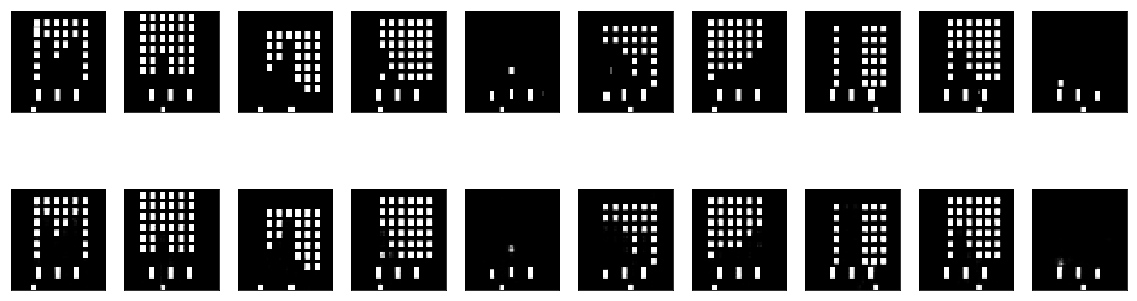

In [15]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(57, 53))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(57, 53))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
decoded_imgs[1]

In [ ]:
encoded_images[1]

In [ ]:
data_paths

In [16]:
autoencoder.save('/home/andres/thesis/models/first_deep.h5')

In [17]:
import h5py

In [18]:
h5f = h5py.File('/home/andres/thesis/models/space_invaders.h5')
h5f.create_dataset('space_invaders', data=data)

<HDF5 dataset "space_invaders": shape (100000, 57, 53), type "<f8">

In [3]:
h5f = h5py.File('/home/andres/thesis/models/space_invaders.h5', 'r')
data = h5f['space_invaders'][:]

In [4]:
data.shape

(100000, 57, 53)